# 1. Загрузка данных

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, random_split

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import kagglehub
from tqdm import tqdm

import imageio
from PIL import Image

In [ ]:
images_path = kagglehub.dataset_download("jessicali9530/lfw-dataset")
print("Path to dataset files:", images_path)

100%|██████████| 112M/112M [00:30<00:00, 3.92MB/s] 


Extracting files...
Path to dataset files: C:\Users\1\.cache\kagglehub\datasets\jessicali9530\lfw-dataset\versions\4


In [ ]:
attrs_path = kagglehub.dataset_download("averkij/lfw-attributes")
print("Path to dataset files:", attrs_path)

100%|██████████| 6.49M/6.49M [00:02<00:00, 3.31MB/s]

Extracting files...
Path to dataset files: C:\Users\1\.cache\kagglehub\datasets\averkij\lfw-attributes\versions\1


In [4]:
# Перекинула датасет и атрибуты в папку с .ipynb
DATASET_PATH ="./lfw-deepfunneled/"
ATTRIBUTES_PATH = "./lfw_attributes.txt"

# 2. Формирование датасета

In [ ]:
def fetch_dataset(dx=80, dy=80, dimx=45, dimy=45):
    df_attrs = pd.read_csv(ATTRIBUTES_PATH, sep='\t', skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns = df_attrs.columns[1:])

    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath, fname)
                photo_id = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person': person_id, 'imagenum': photo_number, 'photo_path': fpath})

    photo_ids = pd.DataFrame(photo_ids)
    df = pd.merge(df_attrs,photo_ids,on=('person', 'imagenum'))

    images = df['photo_path'].apply(imageio.imread)\
                                .apply(lambda img:img[dy:-dy, dx:-dx])\
                                .apply(lambda img: np.array(Image.fromarray(img).resize([dimx, dimy])))

    images = np.stack(images.values).astype('uint8')
    attrs = df.drop(["photo_path", "person", "imagenum"], axis=1)

    return images, attrs

In [6]:
images, attrs = fetch_dataset()

In [7]:
attrs

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,...,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,1.568346,-1.889043,1.737203,-0.929729,-1.471799,-0.19558,-0.835609,-0.351468,-1.012533,-0.719593,...,0.361738,1.166118,-1.164916,-1.13999,-2.371746,-1.299932,-0.414682,-1.144902,0.694007,-0.826609
1,0.169851,-0.982408,0.422709,-1.282184,-1.36006,-0.867002,-0.452293,-0.197521,-0.956073,-0.802107,...,-0.832036,-0.39768,0.87416,-0.945431,-0.268649,-0.006244,-0.030406,-0.480128,0.66676,-0.496559
2,0.997749,-1.364195,-0.157377,-0.756447,-1.891825,-0.871526,-0.862893,0.031445,-1.341523,-0.090037,...,1.549743,1.884745,-0.999765,-1.359858,-1.912108,-1.095634,0.915126,-0.572332,0.144262,-0.841231
3,1.122719,-1.997799,1.916144,-2.514214,-2.580071,-1.404239,0.057551,0.000196,-1.273512,-1.431462,...,0.567822,-0.176089,1.108125,-1.600944,-3.264613,0.813418,0.308631,-0.848693,0.475941,-0.447025
4,1.078214,-2.008098,1.676211,-2.278056,-2.651845,-1.348408,0.649089,0.017656,-1.889111,-1.857213,...,-1.461474,-0.955283,0.119113,-1.128176,-3.161048,0.08268,-0.439614,-0.359859,-0.760774,-0.410152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13138,-0.205363,-0.202842,-1.232735,-1.409125,-1.804858,0.287268,-0.521815,-0.789165,-1.008119,0.531813,...,-0.867156,-0.879554,-0.179497,0.323676,-2.188852,-1.169369,0.924397,-0.217415,-0.414024,-0.495178
13139,1.957472,-2.47247,-1.307994,-0.671636,-1.960125,-0.838803,-1.365955,0.510448,-1.262193,0.418947,...,-2.487289,2.608861,-0.95419,-1.599463,-1.23822,-1.187034,1.87413,-0.832614,0.152785,-0.554331
13140,-0.037001,-1.16415,0.228494,0.187503,-1.836475,-0.958412,-0.669697,-0.48033,0.493433,-1.893151,...,-1.938639,-0.49108,0.495067,-0.524767,-1.073731,0.11101,0.976262,-0.453027,-0.399981,-1.078655
13141,0.282219,-0.396198,1.27047,-1.981209,-1.70294,-1.507203,-2.330721,-0.295928,1.056618,-1.613698,...,-0.662101,-1.692131,1.284772,-0.80818,-0.710051,0.694621,0.936065,-0.7675,1.14693,-0.26094


In [8]:
attrs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13143 entries, 0 to 13142
Data columns (total 73 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Male                        13143 non-null  object
 1   Asian                       13143 non-null  object
 2   White                       13143 non-null  object
 3   Black                       13143 non-null  object
 4   Baby                        13143 non-null  object
 5   Child                       13143 non-null  object
 6   Youth                       13143 non-null  object
 7   Middle Aged                 13143 non-null  object
 8   Senior                      13143 non-null  object
 9   Black Hair                  13143 non-null  object
 10  Blond Hair                  13143 non-null  object
 11  Brown Hair                  13143 non-null  object
 12  Bald                        13143 non-null  object
 13  No Eyewear                  13143 non-null  ob

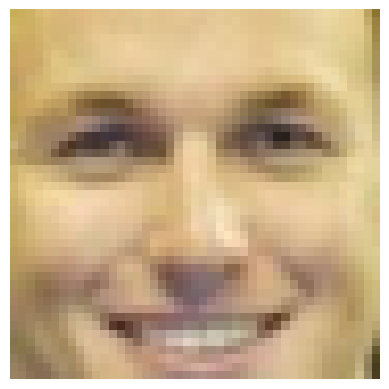

In [11]:
plt.imshow(images[5])
plt.axis('off') 
plt.show()

Кастомный датасет, содержащий картинки и атрибуты

In [ ]:
class ImageAttrDataset(Dataset):
    def __init__(self, images, attrs):
        self.images = images
        self.attrs = attrs

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        image = image.astype(np.float32) / 255.0  
        image = torch.tensor(image).permute(2, 0, 1)
    
        attr = self.attrs.iloc[idx].values
        attr = np.array(attr, dtype=np.float32)
        attr = torch.tensor(attr)
        
        return image, attr

In [14]:
dataset = ImageAttrDataset(images, attrs)

In [15]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [16]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 3. Модель и обучение

In [ ]:
dim_code = 128 # размер латентного вектора
device = 'cuda'

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, dim_code, attr_dim):
        super().__init__()
        # Энкодер для изображений
        self.encoder_img = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),    
            nn.ReLU(),
            nn.MaxPool2d(2),                  
            
            nn.Conv2d(32, 64, 3, padding=1),    
            nn.ReLU(),
            nn.MaxPool2d(2),                   
            
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),                   
        )

        self.flatten = nn.Flatten()
        self.fc_img = nn.Linear(128 * 5 * 5, 1024) 

        # Энкодер для атрибутов
        self.fc_attr = nn.Linear(attr_dim, 128)

        # Латентное пространство
        self.fc_latent = nn.Linear(1024 + 128, dim_code)

        # Декодер
        self.fc_decode = nn.Linear(dim_code, 1024 + 128)
        self.fc_img_decode = nn.Linear(1024 + 128, 128 * 5 * 5)

        self.decoder_img = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),   
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),    #
            nn.Upsample(size=(45, 45), mode='bilinear', align_corners=False),  
            nn.Sigmoid()
        )

    def forward(self, x_img, x_attr):
        # Энкодинг изображения
        x = self.encoder_img(x_img)
        x = self.flatten(x)
        x_img_encoded = self.fc_img(x)

        # Энкодинг атрибутов
        x_attr_encoded = self.fc_attr(x_attr)

        # Латентное пространство
        x_combined = torch.cat([x_img_encoded, x_attr_encoded], dim=1)
        latent_code = self.fc_latent(x_combined)

        # Декодинг
        x_decoded = self.fc_decode(latent_code)
        x_img_decoded = self.fc_img_decode(x_decoded)
        x_img_decoded = x_img_decoded.view(-1, 128, 5, 5)  # Преобразуем обратно в форму, совместимую с декодером
        reconstruction = self.decoder_img(x_img_decoded)

        return reconstruction, latent_code
    
    def sample(self, z):
        x_decoded = self.fc_decode(z)  
        x_img_decoded = self.fc_img_decode(x_decoded) 
        x_img_decoded = x_img_decoded.view(-1, 128, 5, 5)  

        reconstruction = self.decoder_img(x_img_decoded) 
        return reconstruction

In [ ]:
criterion = nn.MSELoss()
autoencoder_ae = Autoencoder(dim_code, len(attrs.columns))
optimizer = optim.Adam(autoencoder_ae.parameters(), lr=1e-3)

In [ ]:
def train_autoencoder(model, train_dataset, val_dataset, criterion, optimizer, num_epochs=10, batch_size=32, device='cuda'):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = model.to(device)

    train_losses = []
    val_losses = []

    # Заранее выберем 3 картинки для отрисовки
    sample_imgs, sample_attrs = next(iter(val_loader))
    sample_imgs = sample_imgs[:3]
    sample_attrs = sample_attrs[:3]

    # Тренировка
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Training", leave=False)
        for imgs, attrs in train_loader_tqdm:
            imgs, attrs = imgs.to(device), attrs.to(device)

            optimizer.zero_grad()
            outputs, _ = model(imgs, attrs)
            loss = criterion(outputs, imgs)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * imgs.size(0)

            train_loader_tqdm.set_postfix(loss=loss.item())

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Валидация
        model.eval()
        val_running_loss = 0.0

        with torch.no_grad():
            val_loader_tqdm = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Validation", leave=False)
            for imgs, attrs in val_loader_tqdm:
                imgs, attrs = imgs.to(device), attrs.to(device)
                outputs, _ = model(imgs, attrs)
                loss = criterion(outputs, imgs)
                val_running_loss += loss.item() * imgs.size(0)

        epoch_val_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

        # Рисуем восстановленную картинку на последней эпохе
        if epoch == num_epochs - 1:
            model.eval()
            with torch.no_grad():
                sample_imgs_device = sample_imgs.to(device)
                sample_attrs_device = sample_attrs.to(device)
                reconstructions, _ = model(sample_imgs_device, sample_attrs_device)
                reconstructions = reconstructions.cpu()

                fig, axes = plt.subplots(1, 3, figsize=(12, 4))
                for i in range(3):
                    # Восстановленное изображение
                    axes[i].imshow(reconstructions[i].permute(1, 2, 0))
                    axes[i].set_title("Reconstructed")
                    axes[i].axis('off')

                plt.suptitle(f"Epoch {epoch+1}")
                plt.tight_layout()
                plt.show()
    
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    for i in range(3):
        # Исходное изображение
        axes[i].imshow(sample_imgs[i].permute(1, 2, 0))
        axes[i].set_title("Original")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()  
    return train_losses, val_losses

Epoch 1/10 | Train Loss: 0.0178 | Val Loss: 0.0102


Epoch 2/10 | Train Loss: 0.0084 | Val Loss: 0.0073


Epoch 3/10 | Train Loss: 0.0066 | Val Loss: 0.0065


Epoch 4/10 | Train Loss: 0.0057 | Val Loss: 0.0054


Epoch 5/10 | Train Loss: 0.0050 | Val Loss: 0.0049


Epoch 6/10 | Train Loss: 0.0047 | Val Loss: 0.0052


Epoch 7/10 | Train Loss: 0.0043 | Val Loss: 0.0043


Epoch 8/10 | Train Loss: 0.0040 | Val Loss: 0.0042


Epoch 9/10 | Train Loss: 0.0038 | Val Loss: 0.0039


Epoch 10/10 | Train Loss: 0.0037 | Val Loss: 0.0040


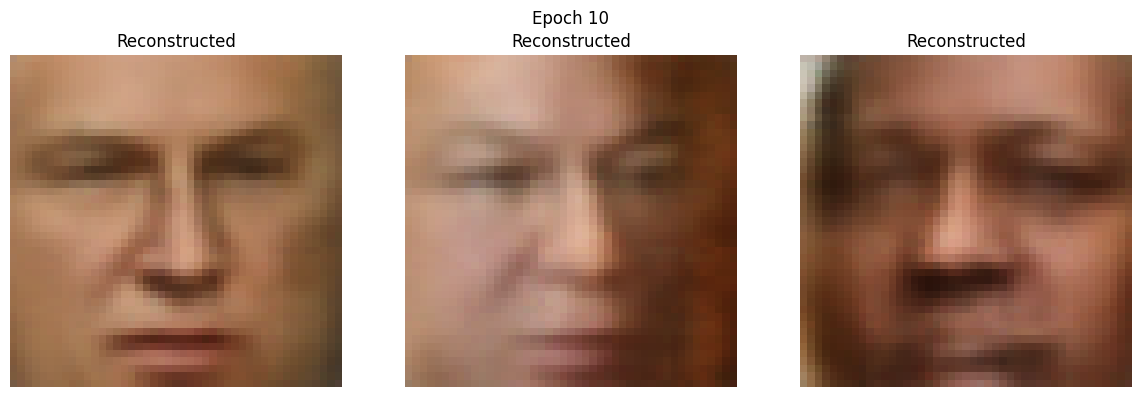

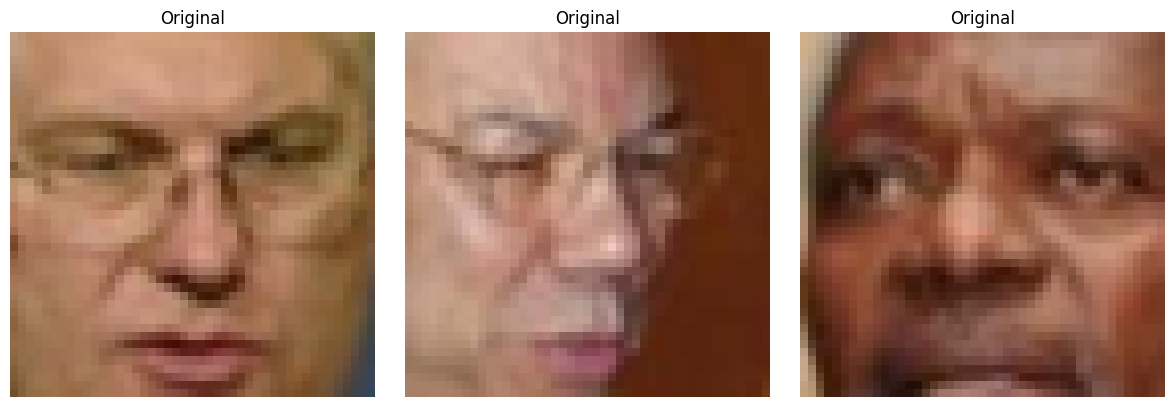

In [25]:
train_losses, val_losses = train_autoencoder(autoencoder_ae, train_dataset, val_dataset, criterion, optimizer, num_epochs=10, batch_size=64, device='cuda')

В целом модель улавливает общие черты

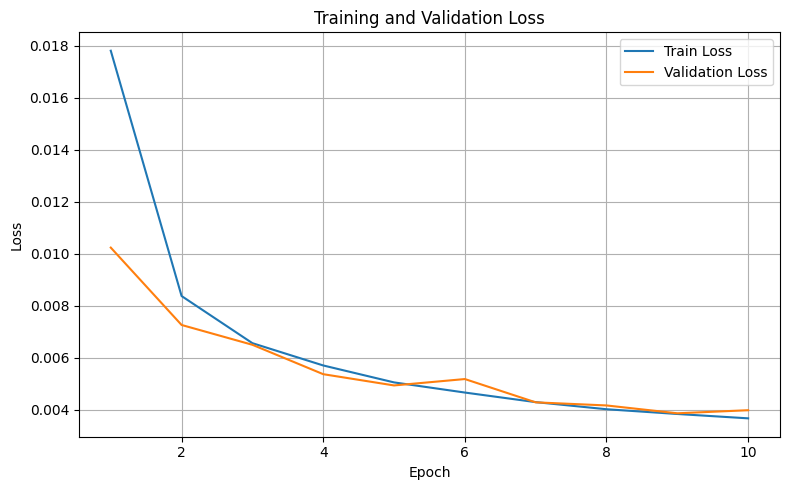

In [ ]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Добавление улыбки

In [29]:
attrs[attrs['Smiling']>1.0]['Smiling'].head(15)

5       1.32771
8      1.043395
9      1.273193
11     1.042788
26     1.512026
34     1.076277
60     1.066129
83     1.037725
88     2.530441
96     1.213427
101    1.359332
106    1.637687
108    2.553645
132    1.227324
135    2.562498
Name: Smiling, dtype: object

In [30]:
index_smile = attrs[attrs['Smiling']>1.0]['Smiling'].head(15).index.to_list()

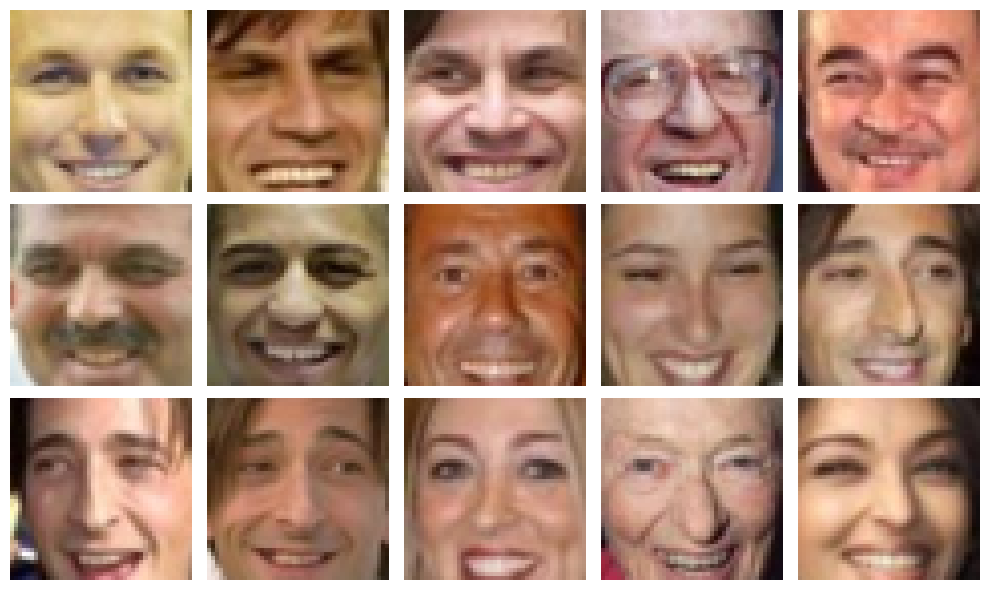

In [31]:
smile_images = images[index_smile]
n_rows=3
n_cols=5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
for i in range(n_rows * n_cols):
    row = i // n_cols
    col = i % n_cols
    axes[row, col].imshow(smile_images[i])
    axes[row, col].axis("off")
plt.tight_layout()
plt.show()

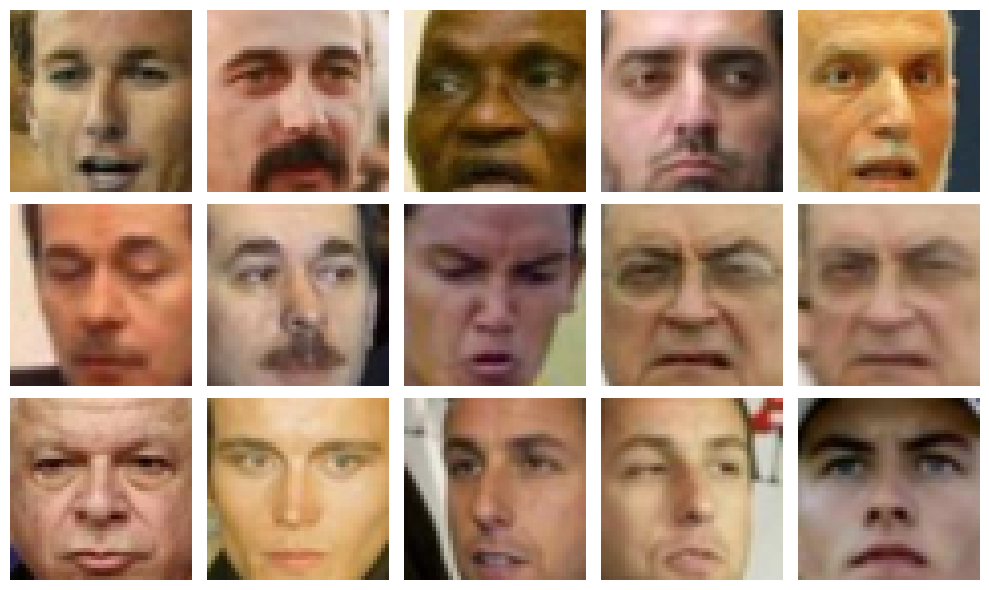

In [32]:
index_sad = attrs[attrs['Smiling']<-1.0]['Smiling'].head(15).index.to_list()
sad_images = images[index_sad]
n_rows=3
n_cols=5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
for i in range(n_rows * n_cols):
    row = i // n_cols
    col = i % n_cols
    axes[row, col].imshow(sad_images[i])
    axes[row, col].axis("off")
plt.tight_layout()
plt.show()

In [33]:
smile_dataset = Subset(dataset, index_smile)
sad_dataset = Subset(dataset, index_sad)

smile_loader = DataLoader(smile_dataset, batch_size=15, shuffle=False)
sad_loader = DataLoader(sad_dataset, batch_size=15, shuffle=False)

In [34]:
images, attrs = next(iter(smile_loader))
images, attrs = images.to(device), attrs.to(device)
output, latent_smile = autoencoder_ae(images, attrs) # для улыбок

In [35]:
images, attrs = next(iter(sad_loader))
images, attrs = images.to(device), attrs.to(device)
output, latent_sad = autoencoder_ae(images, attrs) # для грустных

Получим средние латентные векторы для улыбающегося и грустного человека

In [ ]:
avg_smile = torch.mean(latent_smile, dim=0) 
avg_sad = torch.mean(latent_sad, dim=0)

In [ ]:
diff_smile = avg_smile - avg_sad # эту разницу будем добавлять ко всем лицам
to_model = []
for i in latent_sad:
    to_model.append(i + diff_smile)

to_model = torch.stack(to_model)

In [38]:
output_to_smile = autoencoder_ae.sample(to_model)

In [39]:
def show_samples(samples, n_rows=5, n_cols=5):
    samples = samples.detach().cpu().numpy().transpose(0, 2, 3, 1) 

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
    for i in range(n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        axes[row, col].imshow(samples[i])
        axes[row, col].axis("off")
    plt.tight_layout()
    plt.show()

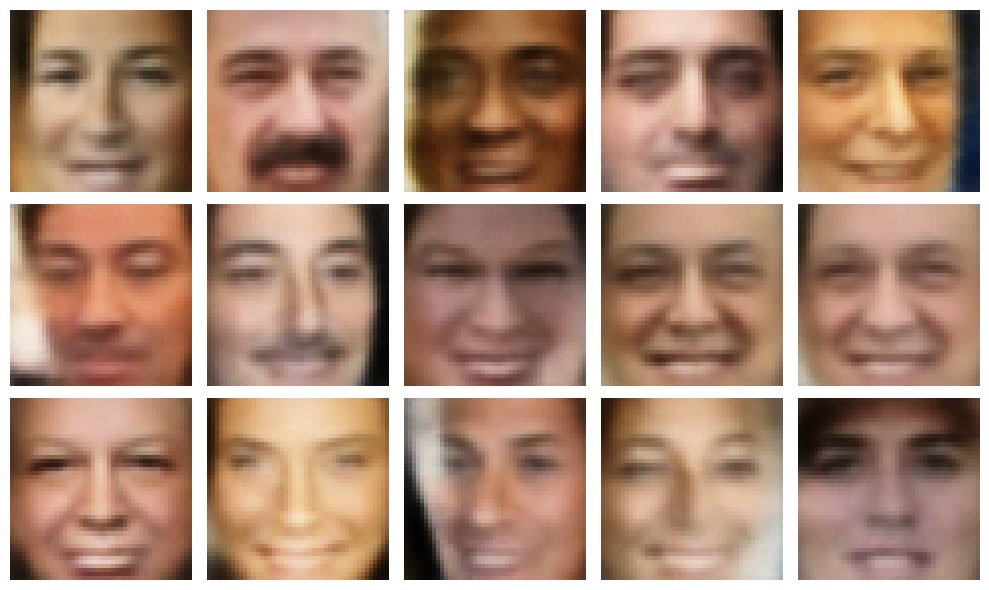

In [40]:
show_samples(output_to_smile, n_rows=3, n_cols=5)

Все улыбаются! :)